#  Projet 8 : Déployez un modèle dans le cloud

La start-up "Fruits!" est une jeune entreprise qui travaille dans le domaine de l'AgriTech. Elle cherche à proposer des solutions innovantes pour la récolte des fruits en développant des robots cueilleurs intelligents.

Cette start-up, souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

Les missions attribuées dans ce sens est de développer dans un environnement Big Data une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension.

## 0. Importations des bibliothèques  : </div> 

In [1]:
import io
import os 
import warnings

import boto3
import findspark
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
findspark.init("/home/ubuntu/spark-3.0.3-bin-hadoop2.7")


from pyspark import SparkContext, Row, SparkConf
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.sql import SparkSession
from pyspark.sql.functions import (split, 
                                   size,
                                   col,
                                   input_file_name,
                                   udf,
                                   pandas_udf,
                                   PandasUDFType,
                                  )
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array



warnings.filterwarnings('ignore')

2022-03-20 18:15:01.815286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-20 18:15:01.815329: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 1. Création de la session spark : 

Le point d'entrée de toute application Spark est la définition d'une session spark. 
La session spark permet d'instancier spark sur le cluster et de définir les ressources qu'elle utilisera pour s'exécuter dans le cluster.Le SparkSession builder contient des méthodes qui permettent de spécifier la configuration de la session Spark. Ces méthodes sont : 
* appName : pour définir le nom de l'application qui sera affiché dans le Spark Web UI
* config : pour indiquer une configuration spécifique dans notre cas ACCES_KEY , SECRET_KEY 
* getOrCreate() : pour créer la session Spark sur la base des paramètres, ou  appeler une session Spark existante. 

In [2]:
spark  = SparkSession.builder \
                    .appName("P8") \
                    .config('spark.hadoop.fs.s3a.access.key', os.environ['ACCESS_KEY'])\
                    .config('spark.hadoop.fs.s3a.secret.key', os.environ['SECRET_KEY'])\
                    .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')\
                    .getOrCreate()

sc = spark.sparkContext

sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.eu-west-1.amazonaws.com")
sc.setSystemProperty("com.amazonaws.services.s3.enableV4", "true")



22/03/20 18:15:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### 2. Chargement des données : 

la création d'une dataframe se fait principalement à partir de la méthode read() d'une session spark qui permet de peupler un dataframe à partir de plusieurs sources de données, telles que les csv, les rdd, les BD externes.

In [3]:
NAME_BUCKET = 'oc-in2-p8'
s3_url = f's3a://{NAME_BUCKET}/data/*'
data= (spark.read.format('binaryFile')
       .option("pathGlobFilter", "*.jpg")
       .option("recursiveFileLookup", "true")
       .load(s3_url))
collect = data.select('content').collect()
data = data.drop("modificationTime", "length")
data = data.withColumn('label', split(data.path, '/').getItem(4))
data.show(truncate=20)

+--------------------+--------------------+--------+
|                path|             content|   label|
+--------------------+--------------------+--------+
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pineable|
|s3a://oc-in2-p8/d...|[FF D8 FF E0 00 1...|pin

###### Exemple sur une seule image  : 

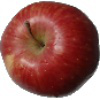

In [4]:
first_img = collect[30][0]
image_1 =Image.open(io.BytesIO(first_img ))
image_1.show()

In [5]:
w, h = image_1.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

Largeur : 100 px, hauteur : 100 px


###  3. Préparation du modèle  : 

La recherche des features se fera grâce à un CNN réseau de neurones qui se basera sur le modèle ResNet50 pré-entrainé sur une base d'images riche (Imagenet).

Le modèle utilisé est un modèle de base sans ajout d'autres couches. le but ici et l'extraction des features ou les points d'intêret. 

In [6]:
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
model.summary() 


2022-03-20 18:16:39.074212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-20 18:16:39.074257: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-20 18:16:39.074287: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-12-116.eu-west-1.compute.internal): /proc/driver/nvidia/version does not exist
2022-03-20 18:16:39.074543: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

Les workers de Spark ont besoin d'accéder au modèle et à ses poids. Téléchargement du modèle vers le pilote Spark, puis diffusion des poids aux workers dirigés par le sc (sparkContext).


La fonction suivante renvoie un modèle ResNet50 avec la couche supérieure supprimée et les poids pré-entraînés diffusés.


In [7]:
bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights='imagenet', pooling='avg', include_top=False)
    model.set_weights(bc_model_weights.value)
    return model




###  4. Preprocessing sur les images  : 

Le but de la fonction suivante est d'ouvrir les images en leurs formes binaires avec Image.open et de les convertir ensuite en tableau pour les préparer à l'étape de suivante qui est le preprocessing ResNet50

In [8]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)) 
    arr = img_to_array(img) 
    return preprocess_input(arr)


###  5. Extraction des features  : 

La fonction suivante va appliquer le preprocessing à la totalité des images. L'application du preprocessing va être d'une façon verticale au lieu d'horizontale avec np.stack


In [9]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input) # Prédiction grâce au modèle RestNet50 
    output = [p.flatten() for p in preds] # Aplatissement de la sortie avec la fonction faltten()
    return pd.Series(output) 

Cette méthode est un Scalar Iterato pandas UDF enveloppant notre fonction de featurisation.
Le décorateur spécifie que cette méthode renvoie une colonne Spark DataFrame de type ArrayType(FloatType).

In [10]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
    '''
    
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

In [11]:
# Les UDF de Pandas sur de grands enregistrements (par exemple, de très grandes images) peuvent rencontrer des erreurs de type Out Of Memory (OOM).
# Si vous rencontrez de telles erreurs dans la cellule ci-dessous, essayez de réduire la taille du lot Arrow via `maxRecordsPerBatch
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [12]:
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

###### Application de l'extraction des features sur l'ensemble de la dataframe spark 

In [13]:
data_features = data.repartition(16).select(col('path'), col('label'), featurize_udf('content').alias('features'))
data_features = data_features.withColumn("features_udf", list_to_vector_udf(col("features")))

In [14]:
data_features.show()

2022-03-20 18:17:10.153539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-20 18:17:10.153583: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-20 18:17:12.287905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-20 18:17:12.287946: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-20 18:17:12.287969: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-12-116.eu-west-1.compute.internal): /proc/driver/nvidia/version does not exist
2022-03-20 18:17:12.288181: I ten

+--------------------+--------+--------------------+--------------------+
|                path|   label|            features|        features_udf|
+--------------------+--------+--------------------+--------------------+
|s3a://oc-in2-p8/d...|pineable|[0.0, 0.5089332, ...|[0.0,0.5089331865...|
|s3a://oc-in2-p8/d...|pineable|[0.038451336, 0.0...|[0.03845133632421...|
|s3a://oc-in2-p8/d...| avocado|[0.21908304, 0.83...|[0.21908304095268...|
|s3a://oc-in2-p8/d...| avocado|[0.48797998, 2.13...|[0.48797997832298...|
|s3a://oc-in2-p8/d...|  banana|[1.4491284, 1.933...|[1.44912838935852...|
|s3a://oc-in2-p8/d...|   apple|[0.0071535036, 0....|[0.00715350359678...|
|s3a://oc-in2-p8/d...|pineable|[0.0, 0.15702924,...|[0.0,0.1570292413...|
|s3a://oc-in2-p8/d...|  banana|[1.3997504, 0.912...|[1.39975035190582...|
|s3a://oc-in2-p8/d...|   apple|[0.9865763, 0.103...|[0.98657631874084...|
|s3a://oc-in2-p8/d...|  banana|[1.278638, 0.1786...|[1.27863800525665...|
|s3a://oc-in2-p8/d...|pineable|[0.0, 2

### 6. Réduction dimentionnelle : 

In [15]:

scaler = StandardScaler(inputCol="features_udf", outputCol="features_scaled")
data_features = scaler.fit((data_features)).transform(data_features)

2022-03-20 18:17:31.260653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-20 18:17:31.260751: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-20 18:17:33.433976: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-20 18:17:33.434015: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-20 18:17:33.434038: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-12-116.eu-west-1.compute.internal): /proc/driver/nvidia/version does not exist
2022-03-20 18:17:33.434251: I ten

In [16]:
data_features.show()

+--------------------+--------+--------------------+--------------------+--------------------+
|                path|   label|            features|        features_udf|     features_scaled|
+--------------------+--------+--------------------+--------------------+--------------------+
|s3a://oc-in2-p8/d...|pineable|[0.0, 0.5089332, ...|[0.0,0.5089331865...|[0.0,0.8173022286...|
|s3a://oc-in2-p8/d...|pineable|[0.038451336, 0.0...|[0.03845133632421...|[0.06930118945401...|
|s3a://oc-in2-p8/d...| avocado|[0.21908304, 0.83...|[0.21908304095268...|[0.39485533608524...|
|s3a://oc-in2-p8/d...| avocado|[0.48797998, 2.13...|[0.48797997832298...|[0.87949070592463...|
|s3a://oc-in2-p8/d...|  banana|[1.4491284, 1.933...|[1.44912838935852...|[2.61177713584141...|
|s3a://oc-in2-p8/d...|   apple|[0.0071535036, 0....|[0.00715350359678...|[0.01289282390189...|
|s3a://oc-in2-p8/d...|pineable|[0.0, 0.15702924,...|[0.0,0.1570292413...|[0.0,0.2521752408...|
|s3a://oc-in2-p8/d...|  banana|[1.3997504, 0.912..

In [17]:
data_features.select(size(col("features"))).show(1)

+--------------+
|size(features)|
+--------------+
|          2048|
+--------------+
only showing top 1 row



In [18]:
nb_composante = len(data_features.select('features').take(1)[0][0])
nb_composante

2022-03-20 18:18:24.035399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-20 18:18:24.035445: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-20 18:18:26.160038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-20 18:18:26.160076: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-20 18:18:26.160098: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-12-116.eu-west-1.compute.internal): /proc/driver/nvidia/version does not exist
2022-03-20 18:18:26.160308: I ten

2048

In [19]:
pca = PCA(k=nb_composante, inputCol="features_scaled", outputCol="features_reduced")
model_pca = pca.fit(data_features)
data_final = model_pca.transform(data_features)

2022-03-20 18:18:37.821007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-20 18:18:37.821541: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-20 18:18:40.085743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-20 18:18:40.085841: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-20 18:18:40.085880: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-12-116.eu-west-1.compute.internal): /proc/driver/nvidia/version does not exist
2022-03-20 18:18:40.086111: I ten

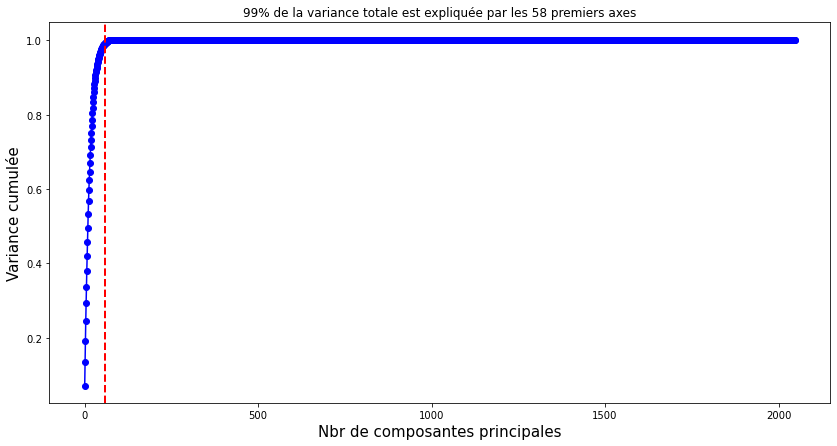

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(model_pca.explainedVariance.cumsum(), c='blue' , marker ='o')
plt.ylabel("Variance cumulée", fontsize= 15)
plt.xlabel('Nbr de composantes principales', fontsize= 15)

seuil = 99
explained_variance = model_pca.explainedVariance*100
cumsum_variance = explained_variance.cumsum()

X_idx = np.where(cumsum_variance >= seuil)[0]
nb_composante = X_idx[cumsum_variance[X_idx].argmin()]+1
plt.axvline(x=nb_composante, linestyle="--", color="red",linewidth=2)

plt.title("{}% de la variance totale est expliquée"\
            " par les {} premiers axes".format(seuil,nb_composante))

plt.show()

In [21]:
data_final = data_final.select(col('path'), col('label'), col('features_reduced'))

In [22]:
data_final.show()

22/03/20 18:20:27 WARN DAGScheduler: Broadcasting large task binary with size 32.0 MiB
22/03/20 18:20:30 WARN DAGScheduler: Broadcasting large task binary with size 32.0 MiB
2022-03-20 18:20:31.519314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-20 18:20:31.529380: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-20 18:20:33.816316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-20 18:20:33.816870: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-20 18:20:33.817134: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel

+--------------------+--------+--------------------+
|                path|   label|    features_reduced|
+--------------------+--------+--------------------+
|s3a://oc-in2-p8/d...|pineable|[6.61604271410092...|
|s3a://oc-in2-p8/d...|pineable|[5.31961876712096...|
|s3a://oc-in2-p8/d...| avocado|[7.60184157205863...|
|s3a://oc-in2-p8/d...| avocado|[-0.7133216226531...|
|s3a://oc-in2-p8/d...|  banana|[-34.797717159259...|
|s3a://oc-in2-p8/d...|   apple|[4.98497085750738...|
|s3a://oc-in2-p8/d...|pineable|[6.94829611140836...|
|s3a://oc-in2-p8/d...|  banana|[-27.002514653621...|
|s3a://oc-in2-p8/d...|   apple|[1.40586674649972...|
|s3a://oc-in2-p8/d...|  banana|[-30.686397198797...|
|s3a://oc-in2-p8/d...|pineable|[5.03630023685520...|
|s3a://oc-in2-p8/d...|pineable|[2.55525919376473...|
|s3a://oc-in2-p8/d...|  banana|[-32.549908213142...|
|s3a://oc-in2-p8/d...|  banana|[-25.058560866194...|
|s3a://oc-in2-p8/d...|  banana|[-32.326808449741...|
|s3a://oc-in2-p8/d...|pineable|[3.247257005181

In [23]:
data_final_pd = data_final.toPandas()

22/03/20 18:20:42 WARN DAGScheduler: Broadcasting large task binary with size 32.1 MiB


In [33]:
data_final_pd

,path,label,features_reduced
0,s3a://oc-in2-p8/data/pineable/r_1_100.jpg,pineable,"[6.616042714100934, -21.302603642638083, -14.3..."
1,s3a://oc-in2-p8/data/pineable/r_99_100.jpg,pineable,"[5.3196187671209785, -20.784546682094977, -15...."
2,s3a://oc-in2-p8/data/avocado/116_100.jpg,avocado,"[7.6018415720586265, 27.45124192542639, -21.24..."
3,s3a://oc-in2-p8/data/avocado/r_142_100.jpg,avocado,"[-0.7133216226531506, 14.988496899652775, -6.6..."
4,s3a://oc-in2-p8/data/banana/263_100.jpg,banana,"[-34.79771715925994, 5.453574670287678, -11.30..."
...,...,...,...
75,s3a://oc-in2-p8/data/apple/r_278_100.jpg,apple,"[1.9682519295549483, 2.9817454770611613, 16.75..."
76,s3a://oc-in2-p8/data/apple/177_100.jpg,apple,"[3.06477380269612, 6.0157417000212945, 8.79574..."
77,s3a://oc-in2-p8/data/avocado/r_31_100.jpg,avocado,"[4.343664698511755, 13.891744926758832, -4.564..."
78,s3a://oc-in2-p8/data/avocado/183_100.jpg,avocado,"[12.48138100539999, 31.632679933735464, -28.60..."


### 7.Stockage sur le bucket S3 : 

In [37]:

data_final.withColumn("features_reduced", col("features_reduced").cast("string")).coalesce(1).write.option("header","true").mode("Overwrite").csv(path="s3a://oc-in2-p8/features_image")

2022-03-19 19:36:55.840150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-19 19:36:55.840189: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-19 19:36:58.089081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-19 19:36:58.089124: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-19 19:36:58.089149: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-95-242.ec2.internal): /proc/driver/nvidia/version does not exist
2022-03-19 19:36:58.089387: I tensorflow/core/p